In [ ]:
from datasets import load_from_disk
from sklearn.model_selection import train_test_split
import torch

dataset = load_from_disk("./iemocap_precomputed")

emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'frustrated', 'excited', 'fear', 'disgust', 'surprise', 'other']
num_classes = len(emotion_labels)

label_to_idx = {label: idx for idx, label in enumerate(emotion_labels)}

full_data = dataset['train']
full_data_list = full_data.to_list()

import random
random.seed(42)
random.shuffle(full_data_list)

# Split into train (80%), val (10%), and test (10%)
train_data, temp_data = train_test_split(full_data_list, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

train_dataset = dataset["train"].select(range(len(train_data)))
val_dataset = dataset["train"].select(range(len(train_data), len(train_data) + len(val_data)))
test_dataset = dataset["train"].select(range(len(train_data) + len(val_data), len(full_data_list)))

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")


Train size: 8031
Validation size: 1004
Test size: 1004


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from torch.utils.data import Dataset

class IEMOCAPDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)


    def __getitem__(self, idx):
        sample = self.dataset[idx]

        audio_emb = torch.tensor(sample['audio_embedding']).float() # (768,)
        text_emb = torch.tensor(sample["text_embedding"]).float() # (768,)
        label = torch.tensor(sample["label_id"], dtype=torch.long)

        return {"audio_emb": audio_emb, "text_emb": text_emb, "labels": label}

train_ds = IEMOCAPDataset(train_dataset)
val_ds = IEMOCAPDataset(val_dataset)
test_ds = IEMOCAPDataset(test_dataset)

### MLP Classifier

In [ ]:
import torch.nn as nn

# Linear classifier 1536 -> relu(512) -> 10
class MLP(nn.Module):
    def __init__(self, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(768 + 768, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, audio_emb, text_emb, labels=None):
        features = torch.cat((audio_emb, text_emb), dim=1)
        x = self.fc1(features)
        x = self.relu(x)
        x = self.fc2(x)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(x, labels)

        return {"loss": loss, "logits": x} if loss is not None else {"logits": x}
    
mlp_model = MLP(num_classes).to(device)
mlp_model

MLP(
  (fc1): Linear(in_features=1536, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
import numpy as np
import evaluate

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted", zero_division=1)
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": (predictions == labels).mean(),
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

In [6]:
from transformers import TrainingArguments

mlp_training_args = TrainingArguments(
    output_dir="./mlp_model",
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=5e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    fp16=True
)

In [7]:
from transformers import Trainer

mlp_trainer = Trainer(
    model=mlp_model,
    args=mlp_training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

mlp_trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,1.756000,1.607663,0.338645,0.494623,0.338645,0.254699
200,1.618100,1.531548,0.373506,0.531516,0.373506,0.305707
300,1.552400,1.465967,0.446215,0.525345,0.446215,0.413559
400,1.503400,1.485564,0.390438,0.504088,0.390438,0.344026
500,1.451100,1.420366,0.421315,0.469513,0.421315,0.372154
600,1.456800,1.411863,0.452191,0.557729,0.452191,0.400216
700,1.375300,1.369789,0.477092,0.536952,0.477092,0.451656
800,1.351000,1.384332,0.468127,0.556402,0.468127,0.444042
900,1.363200,1.354540,0.488048,0.569116,0.488048,0.457535
1000,1.383300,1.334296,0.510956,0.564917,0.510956,0.481834


TrainOutput(global_step=2510, training_loss=1.3546958209033981, metrics={'train_runtime': 86.924, 'train_samples_per_second': 461.955, 'train_steps_per_second': 28.876, 'total_flos': 0.0, 'train_loss': 1.3546958209033981, 'epoch': 5.0})

In [8]:
import matplotlib.pyplot as plt

def plot_training_progress(trainer):
    train_loss = []
    eval_loss = []
    eval_accuracy = []
    steps = []

    for log in trainer.state.log_history:
        if "loss" in log:
            train_loss.append(log["loss"])
            steps.append(log["step"])
        if "eval_loss" in log:
            eval_loss.append(log["eval_loss"])
        if "eval_accuracy" in log:
            eval_accuracy.append(log["eval_accuracy"])

    eval_steps = steps[:len(eval_loss)]

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(steps, train_loss, label="Training Loss", linestyle="-", color="blue")
    plt.plot(eval_steps, eval_loss, label="Validation Loss", linestyle="--", color="red")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(eval_steps, eval_accuracy, marker="o", linestyle="-", color="blue", label="Validation Accuracy")
    plt.xlabel("Training Steps")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Over Training")
    plt.legend()
    plt.grid()
    plt.show()

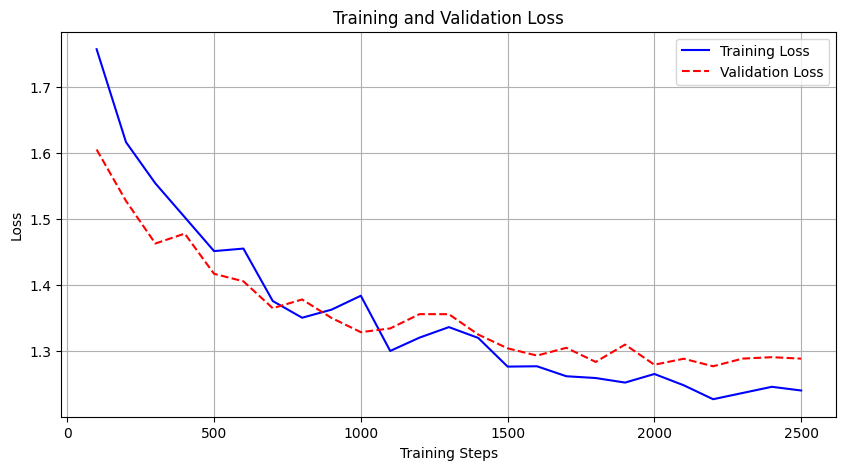

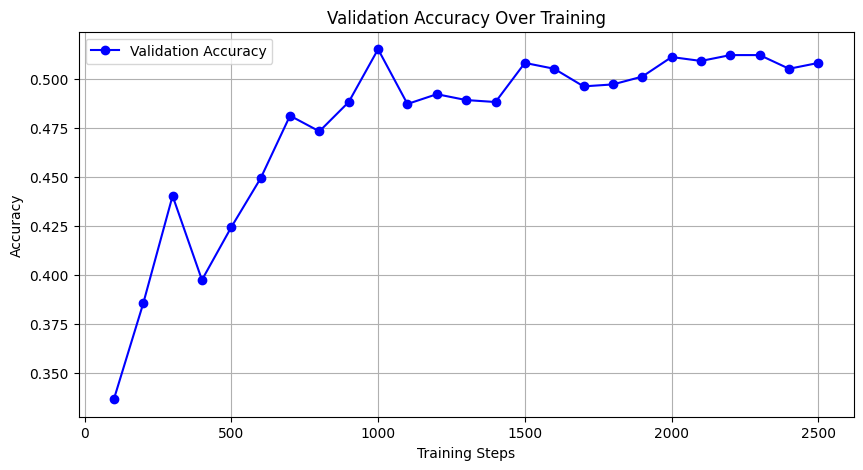

In [43]:
plot_training_progress(mlp_trainer)

In [27]:
def test_report(test_results):
    print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")
    print(f"Test Precision: {test_results['eval_precision']:.4f}")
    print(f"Test Recall: {test_results['eval_recall']:.4f}")
    print(f"Test F1-Score: {test_results['eval_f1']:.4f}")

In [28]:
test_report(mlp_trainer.evaluate(test_ds))

Test Accuracy: 0.4880
Test Precision: 0.5021
Test Recall: 0.4880
Test F1-Score: 0.4634


### Cross Attention Fusion

In [52]:
from collections import Counter

labels = [sample["label_id"] for sample in dataset["train"]]
label_counts = Counter(labels)

print("class distribution:", label_counts)

# class_weights = torch.tensor([1 / (count ** 0.5) for count in label_counts.values()], dtype=torch.float).to(device)
# print("class weights:", class_weights)

class distribution: Counter({4: 2917, 5: 1976, 0: 1726, 3: 1269, 2: 1250, 1: 656, 8: 110, 6: 107, 9: 26, 7: 2})


In [ ]:
# Does not work because sequence length is always 1
class CrossAttentionFusion(nn.Module):
    def __init__(self, num_classes=10, hidden_dim=512):
        super(CrossAttentionFusion, self).__init__()

        self.audio_proj = nn.Linear(768, hidden_dim)
        self.text_proj = nn.Linear(768, hidden_dim)

        self.audio_to_text_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.text_to_audio_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim * 2, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, audio_emb, text_emb, labels=None):
        audio_emb = self.audio_proj(audio_emb).unsqueeze(1)
        text_emb = self.text_proj(text_emb).unsqueeze(1)

        audio_to_text, _ = self.audio_to_text_attention(audio_emb, text_emb, text_emb)
        text_to_audio, _ = self.text_to_audio_attention(text_emb, audio_emb, audio_emb)

        fused_features = torch.cat((audio_to_text.squeeze(1), text_to_audio.squeeze(1)), dim=1)
        x = self.fc1(fused_features)
        x = self.relu(x)
        x = self.fc2(x)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(x, labels)

        return {"loss": loss, "logits": x} if loss is not None else {"logits": x}

cross_attention_model = CrossAttentionFusion().to(device)
cross_attention_model

CrossAttentionFusion(
  (audio_proj): Linear(in_features=768, out_features=512, bias=True)
  (text_proj): Linear(in_features=768, out_features=512, bias=True)
  (audio_to_text_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (text_to_audio_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [48]:
cross_attention_training_args = TrainingArguments(
    output_dir="./cross_attention_model",
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=5e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    fp16=True
)

In [49]:
cross_attention_trainer = Trainer(
    model=cross_attention_model,
    args=cross_attention_training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

cross_attention_trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,1.925800,1.670020,0.320717,0.390601,0.320717,0.204544
200,1.806500,1.669964,0.355578,0.448684,0.355578,0.309215
300,1.743900,1.536983,0.373506,0.496640,0.373506,0.320181
400,1.707000,1.583705,0.383466,0.442623,0.383466,0.328881
500,1.570600,1.456699,0.445219,0.496172,0.445219,0.387452
600,1.612300,1.427623,0.432271,0.535461,0.432271,0.379443
700,1.507500,1.441157,0.450199,0.468139,0.450199,0.430875
800,1.570100,1.392609,0.453187,0.515381,0.453187,0.433786
900,1.523300,1.379440,0.487052,0.513355,0.487052,0.457678
1000,1.525200,1.336209,0.472112,0.548969,0.472112,0.427316


TrainOutput(global_step=2510, training_loss=1.4686721528193865, metrics={'train_runtime': 125.4414, 'train_samples_per_second': 320.11, 'train_steps_per_second': 20.009, 'total_flos': 0.0, 'train_loss': 1.4686721528193865, 'epoch': 5.0})

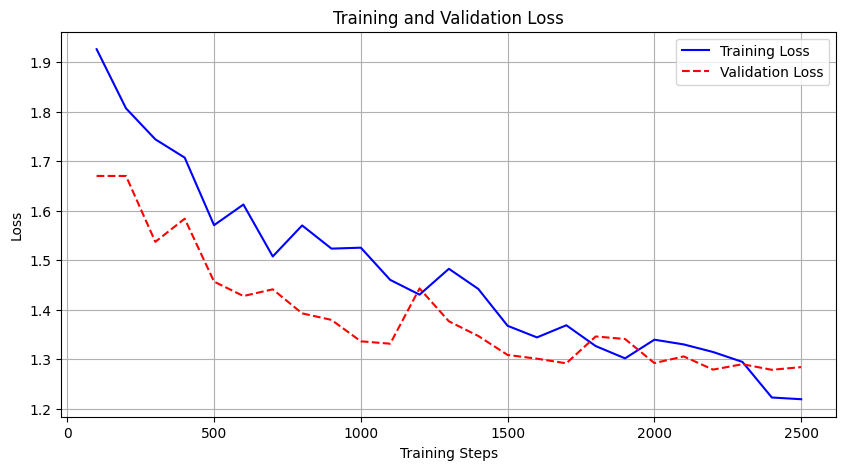

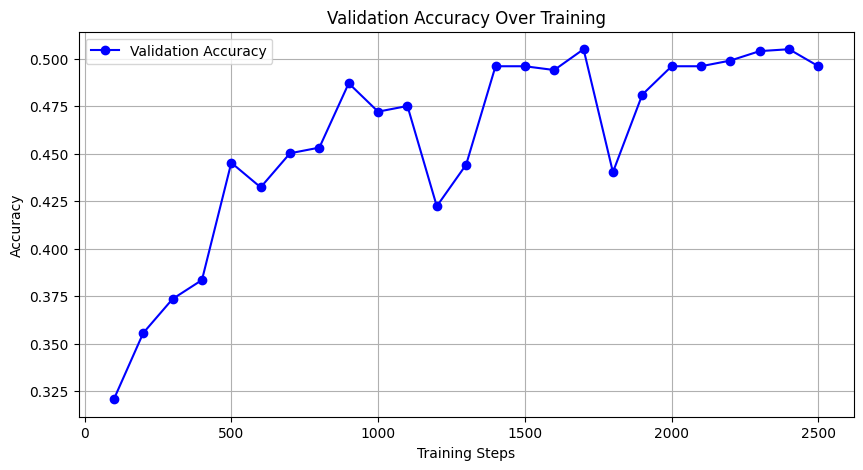

In [50]:
plot_training_progress(cross_attention_trainer)

In [51]:
test_report(cross_attention_trainer.evaluate(test_ds))

Test Accuracy: 0.4950
Test Precision: 0.4844
Test Recall: 0.4950
Test F1-Score: 0.4728


### Weighted Modality

In [58]:
class WeightedModalityFusion(nn.Module):
    def __init__(self, num_classes=10, hidden_dim=512):
        super(WeightedModalityFusion, self).__init__()

        self.audio_proj = nn.Linear(768, hidden_dim)
        self.text_proj = nn.Linear(768, hidden_dim)

        # initial weights of 0.5
        self.alpha = nn.Parameter(torch.tensor(0.5))
        self.beta = nn.Parameter(torch.tensor(0.5))

        self.fc1 = nn.Linear(hidden_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, audio_emb, text_emb, labels=None):
        audio_emb = self.audio_proj(audio_emb)
        text_emb = self.text_proj(text_emb)

        # multiply and add
        fused_features = self.alpha * audio_emb + self.beta * text_emb
        x = self.fc1(fused_features)
        x = self.relu(x)
        x = self.fc2(x)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(x, labels)

        return {"loss": loss, "logits": x} if loss is not None else {"logits": x}

weighted_model = WeightedModalityFusion()
weighted_model

WeightedModalityFusion(
  (audio_proj): Linear(in_features=768, out_features=512, bias=True)
  (text_proj): Linear(in_features=768, out_features=512, bias=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [59]:
weighted_model_training_args = TrainingArguments(
    output_dir="./weighted_model",
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=5e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    fp16=True
)

In [60]:
weighted_model_trainer = Trainer(
    model=weighted_model,
    args=weighted_model_training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

weighted_model_trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,1.772900,1.624074,0.313745,0.463801,0.313745,0.194366
200,1.619100,1.542133,0.378486,0.457582,0.378486,0.342129
300,1.538300,1.452696,0.413347,0.525165,0.413347,0.375720
400,1.468000,1.413936,0.442231,0.509071,0.442231,0.415298
500,1.409000,1.370439,0.464143,0.458445,0.464143,0.411775
600,1.410400,1.342029,0.476096,0.547786,0.476096,0.443152
700,1.303500,1.343295,0.495020,0.548042,0.495020,0.471560
800,1.318900,1.313602,0.494024,0.536129,0.494024,0.474275
900,1.333700,1.303105,0.520916,0.547720,0.520916,0.492096
1000,1.357500,1.293178,0.528884,0.580137,0.528884,0.498212


TrainOutput(global_step=2510, training_loss=1.309219715604744, metrics={'train_runtime': 82.3522, 'train_samples_per_second': 487.601, 'train_steps_per_second': 30.479, 'total_flos': 0.0, 'train_loss': 1.309219715604744, 'epoch': 5.0})

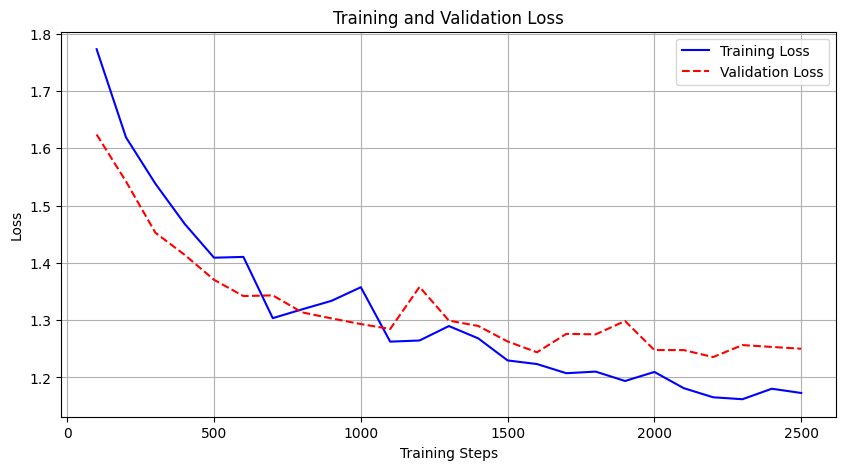

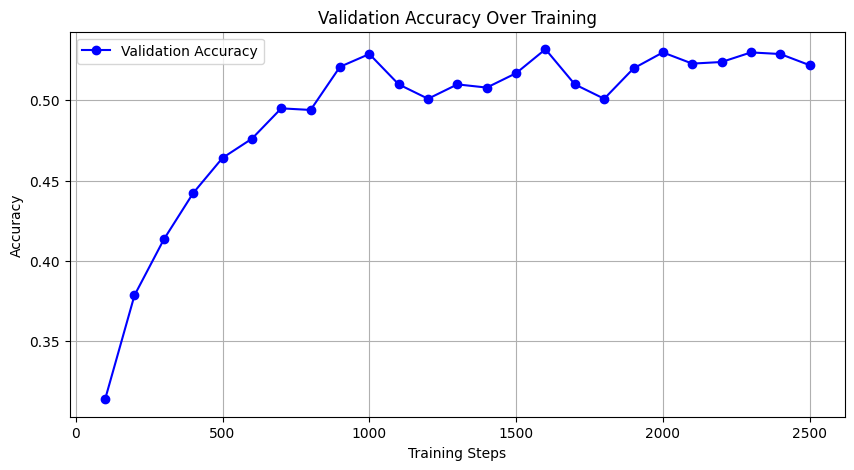

In [62]:
plot_training_progress(weighted_model_trainer)

In [63]:
test_report(weighted_model_trainer.evaluate(test_ds))

Test Accuracy: 0.5000
Test Precision: 0.5245
Test Recall: 0.5000
Test F1-Score: 0.4762
